# Machine Learning Model Pipeline

## Libraries Imported:
- **Pandas**: For data manipulation and analysis.
- **NumPy**: For numerical operations.
- **Scikit-learn**: For machine learning operations:
  - `LabelEncoder`, `StandardScaler`: For preprocessing.
  - `train_test_split`: To split data into training and testing sets.
  - `GridSearchCV`, `StratifiedKFold`: For hyperparameter tuning and cross-validation.
  - `LogisticRegression`, `RandomForestClassifier`: Models used.
  - `accuracy_score`, `precision_score`, `recall_score`: Metrics used to evaluate the models.
- **Imbalanced-learn (SMOTE)**: Used `SMOTE` to handle imbalanced data by oversampling.
- **Seaborn** and **Matplotlib**: For data visualization.
- **Joblib**: For saving the trained models.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
# from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Student Dataset Processing and Feature Engineering

## Dataset:
- I Loaded the student dataset from a CSV file and displayed the first few rows using `head()`.

### Created the Target Variable
- Added a new column `Student Status` to classify students based on their `Mock Exam Score`. If the score is greater than 50, the status is labeled as **Pass**, otherwise **Fail** because the scope of the project is to find proactive solution to detecting students at risk of scoring below average (Fail) or above average (Pass) based on the recent [statistics](https://www.premiumtimesng.com/news/690022-updated-jamb-releases-2024-utme-results-76-scores-below-200.html) from JAMB (a Nigerian pre-tertiary examination governing body)

### Feature Selection:
- I removed columns **SS1 Score**, **SS2 Score**, and **Mock Exam Score** as they were no longer needed for the modelling due to the project instructions to drop previous scores as part of the features to the model.

### Label Encoding:
- Then applied `LabelEncoder` to transform orderly categorical variables into numerical representations. Encoded the following columns:
  - **Family Income (SES)**
  - **Parental Education**
  - **Student-Teacher Relationship**
  - **Student Status**

### One-Hot Encoding:
- Performed one-hot encoding on the following categorical variables that has no inherent order:
  - **Stream**
  - **Gender**
  - **Study Method**

  This created dummy variables for each unique category in the columns.

### Data Merging and Cleanup:
- Then merge the newly created dummy variables back into the main dataset using `pd.concat()`.
- Dropped unnecessary columns like **Student ID**, **Stream**, **Gender**, and **Study Method** after one-hot encoding, as their encoded forms were now present in the data.

### Final Dataframe:
- The final dataset consists of the selected features, encoded variables, and target variable (**Student Status**) ready for modeling.


In [2]:
students = pd.read_csv(r"C:\Users\HP\Desktop\Datathon Data 2\Students.csv")
students.head()

,Student ID,Stream,Gender,Family Income (SES),SS1 Score,SS2 Score,Mock Exam Score,Attendance Rate (%),Distance from Home (km),Study Hours per Day,Extracurricular Activity,Age,Extra Tutoring,Internet Access,Parental Education,Library Usage,Study Method,Student-Teacher Relationship
0,STU012,Science,Male,High,51.09,31.03,58.62,68.04,19.71,2,True,18,True,True,Tertiary,False,Group-study,Weak
1,STU133,Commercial,Female,Low,69.67,50.72,55.74,75.18,23.85,2,True,19,True,False,Elementary,True,Group-study,Weak
2,STU217,Arts,Female,Average,75.19,67.27,89.94,83.32,18.70,3,False,19,True,True,Secondary,False,Group-study,Average
3,STU134,Commercial,Female,Average,55.59,68.46,48.74,85.68,26.63,2,False,17,False,True,Secondary,False,Self-study,Weak
4,STU165,Commercial,Female,Low,55.34,42.27,44.98,72.84,16.04,2,False,19,False,True,Secondary,False,Self-study,Weak


In [3]:
students['Student Status'] = np.where(students['Mock Exam Score'] > 50, 'Pass', 'Fail')


In [4]:
subset = students.drop(['SS1 Score', 'SS2 Score', 'Mock Exam Score'], axis = 1)
lab = LabelEncoder()
# subset[['Family Income (SES)', 'Parental Education', 'Student-Teacher Relationship']] = lab.fit_transform(subset[['Family Income (SES)', 'Parental Education', 'Student-Teacher Relationship']])
subset['Family Income (SES)'] = lab.fit_transform(subset['Family Income (SES)'])
subset['Parental Education'] = lab.fit_transform(subset['Parental Education'])
subset['Student-Teacher Relationship'] = lab.fit_transform(subset['Student-Teacher Relationship'])
subset['Student Status'] = lab.fit_transform(subset['Student Status'])
# subset['Stream'] = pd.get_dummies(subset['Stream'], drop_first = True)
subset_dummies = pd.get_dummies(subset[['Stream', 'Gender', 'Study Method']])
subset_dummies.head()
# subset.head()
subset = pd.concat([subset, subset_dummies], axis = 1)
subset = subset.drop(['Student ID', 'Stream', 'Gender', 'Study Method'], axis = 1)


# Student Dataset Processing and Feature Engineering
## Scaling Features for Different Models

### Dataset Duplication:
- I created a copy of the original dataframe (**subset2**) to be used specifically for the **Random Forest** model, which does not require much scaling for features.

### Numeric Feature Selection:
- However, I selected only the numeric columns from **subset2** using `select_dtypes` with the `float` data type. These columns are:
  - **Attendance Rate (%)**
  - **Distance from Home (km)**

### Standardization:
- I then applied **StandardScaler** to standardize the selected numeric features beacuse they have high varaince:
  - **Attendance Rate (%)**
  - **Distance from Home (km)**
  
  The standardized columns were renamed to:
  - **Attendance Rate Scaled (%)**
  - **Distance from Home Scaled (km)**

### Data Integration:
- Merged the scaled features back into the dataset using `pd.concat()`.
- Removed the original unscaled columns **Attendance Rate (%)** and **Distance from Home (km)** from the dataset to avoid duplication.

### Purpose:
- Since the **Random Forest** model does not require feature scaling, a copy of the dataframe (**subset2**) was maintained without applying scaling to ensure both models can be trained with the appropriate data format.


In [5]:
subset2 = subset.copy()
subset2_numeric = subset2.select_dtypes(include = 'float')
subset2_numeric.columns
scaler2 = StandardScaler()
subset2_numeric_scaled = scaler2.fit_transform(subset2_numeric)
subset2_numeric_scaled_df = pd.DataFrame(subset2_numeric_scaled, columns = ['Attendance Rate Scaled (%)', 'Distance from Home Scaled(km)'])
subset2_numeric_scaled_df
subset = pd.concat([subset2, subset2_numeric_scaled_df], axis = 1)
subset2
subset2 = subset2.drop(['Attendance Rate (%)', 'Distance from Home (km)'], axis = 1)


In [6]:
subset.var()

Family Income (SES)               0.875853
Attendance Rate (%)              77.908694
Distance from Home (km)          10.994258
Study Hours per Day               0.366678
Extracurricular Activity          0.237949
Age                               0.608651
Extra Tutoring                    0.242096
Internet Access                   0.235574
Parental Education                0.657425
Library Usage                     0.250123
Student-Teacher Relationship      0.800491
Student Status                    0.221839
Stream_Arts                       0.222965
Stream_Commercial                 0.222965
Stream_Science                    0.222965
Gender_Female                     0.249487
Gender_Male                       0.249487
Study Method_Group-study          0.248952
Study Method_Self-study           0.248952
Attendance Rate Scaled (%)        1.003344
Distance from Home Scaled(km)     1.003344
dtype: float64

## Data Preparation and Model Training
### Logistic Regression Model
### Feature and Target Split:
- Splitted the dataset into features (**X**) and the target variable (**y**). The target variable is the **Student Status** column, and the rest of the features are used for model training.

### Train-Test Split:
- Used `train_test_split` to split the data into training and test sets with **15%** of the data reserved for testing.
- The split was stratified to maintain the balance of the **Pass/Fail** categories in both the training and test sets.

### SMOTE for Handling Imbalanced Data:
- Then because the data consist of 300 records and class imbalance, I applied **SMOTE (Synthetic Minority Over-sampling Technique)** to oversample the minority class in the training set, ensuring a balanced dataset for the model.
  
### Feature Scaling:
- Standardized the features using **StandardScaler** to ensure all features are on the same scale, which is important for logistic regression models.

### Logistic Regression with Grid Search:
- Initialized a **Logistic Regression** model and defined a hyperparameter grid (`param_grid`) for tuning. The parameters tuned include:
  - **Penalty**: Regularization type (`l1`, `l2`).
  - **C**: Regularization strength (range: 0.01 to 100).
  - **Solver**: Chose `liblinear` as it supports **l1** regularization.
  - **Max Iterations**: Number of iterations to run during training.
  - **Class Weight**: Adjusted to handle class imbalance.

- Used **GridSearchCV** with **StratifiedKFold** cross-validation (6 folds) to find the best hyperparameters for the logistic regression model.

### Best Logistic Regression Model:
- The best logistic regression model was obtained using the grid search, and the model parameters were saved as `best_model_log`.
  
### Model Performance:
- The best training score from cross-validation was **{best_score_logreg:.2%}**, indicating how well the model performs on the training data.


In [7]:
X = subset.drop('Student Status', axis = 1)
y = subset['Student Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, stratify = y, random_state = 10)
smote = SMOTE(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)
k = StratifiedKFold(n_splits = 6, shuffle = True, random_state = 38)
logreg = LogisticRegression(random_state = 10)
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear'],  # Limited to solvers supporting l1 and elasticnet
    'max_iter': [1000, 2000],
    'class_weight': [None, 'balanced']
}
logreg_grid = GridSearchCV(estimator = logreg, cv = k, param_grid = param_grid)
logreg_grid.fit(X_smote, y_smote)
best_model_log = logreg_grid.best_estimator_
best_score_logreg = logreg_grid.best_score_
print(f'Best Training Score : {best_score_logreg:.2%}')



Best Training Score : 75.44%


## Model Evaluation

### Testing the Best Logistic Regression Model:
- After identifying the best logistic regression model from grid search, predictions were made on the test set.

### Evaluation Metrics:
- **Accuracy**: Measures the percentage of correct predictions made by the model.
- **Precision**: Represents the proportion of positive predictions that were actually correct.
- **Recall**: Measures the proportion of actual positives that were correctly predicted by the model.

### Model Performance on Test Data:
- The performance of the logistic regression model on the test set is as follows:
  - **Accuracy**: `log_score2`
  - **Precision**: `log_precision`
  - **Recall**: `log_recall`

### Results:
- The Accuracy of the model is 71.11%
- The Precision of the model is 84.00%
- The Recall of the model is 70.00%

Visualized the feature importance from the logistic regression model using the model's **coefficients**.
- A **barplot** was created to show the relationship between each feature and the model's output.


In [8]:
# y_pred = logreg.predict(X_test)
# score = accuracy_score(y_test, y_pred)
# score
log_pred = best_model_log.predict(X_test_scaled)
log_score2 = accuracy_score(y_test, log_pred)
log_precision = precision_score(y_test, log_pred)
log_recall = recall_score(y_test, log_pred)
print(f'The Accuracy of the model is {log_score2:.2%}')
print(f'The Precision of the model is {log_precision:.2%}')
print(f'The Recall of the model is {log_recall:.2%}')


The Accuracy of the model is 71.11%
The Precision of the model is 84.00%
The Recall of the model is 70.00%


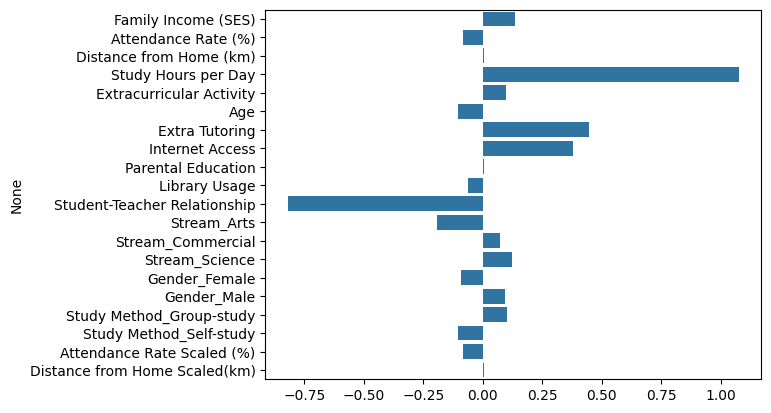

In [9]:
coef = best_model_log.coef_
columns = X.columns 
sns.barplot(y = columns, x = coef.flatten(), orient = 'h')

plt.show()

## Random Forest Model Training and Evaluation

### Data Preparation:
- Prepared a separate dataset (**X2** and **y2**) for the **Random Forest** model.
- Used **SMOTE** to balance the dataset by oversampling the minority class.

### Random Forest with Grid Search:
- Defined a **Random Forest** classifier with `class_weight='balanced'` to handle the class imbalance.
- Performed **GridSearchCV** using the following parameter grid:
  - `n_estimators`: the number of trees in the forest
  - `max_depth`: the maximum depth of the trees 
  - `min_samples_leaf`: the minimum number of samples required at leaf nodes
  - `max_features`: the method for selecting features at each split
- The best model was obtained and saved as `best_model`.

### Model Performance:
- Best training score from grid search was **{best_score:.2%}**.
- Performance on the test set:
  - **Accuracy**: `rfc_score2`
  - **Precision**: `rfc_precision`
  - **Recall**: `rfc_recall`

### Feature Importance Visualization:
- Visualized the feature importances using a **barplot** to show the contribution of each feature to the Random Forest model.



In [10]:
X2 = subset2.drop('Student Status', axis = 1)
y2 = subset2['Student Status']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.15, stratify = y, random_state = 2)
smote2 = SMOTE(random_state=42)
X_smote2, y_smote2 = smote2.fit_resample(X_train2, y_train2)
rfc = RandomForestClassifier(random_state = 38, class_weight = 'balanced')
# rfc.fit(X_train, y_train)
# r_pred = rfc.predict(X_test)
# rfc.get_params()
kf = StratifiedKFold(n_splits = 6, shuffle = True, random_state = 38) #38
params = {'n_estimators' : [50, 100, 200],
          'max_depth' : [3, 5, 10],
          'min_samples_leaf' : [2,4,10],
          'max_features' : ['sqrt', 'log2']} 
grid_cv = GridSearchCV(estimator = rfc, cv = kf, param_grid = params)
grid_cv.fit(X_smote2, y_smote2)
# r_score = accuracy_score(y_test, r_pred)
# r_score
best_model = grid_cv.best_estimator_
best_score = grid_cv.best_score_
print(f'Best Training score Rf: {best_score:.2%}') 


Best Training score Rf: 76.61%


In [11]:
rfc_pred = best_model.predict(X_test2)
rfc_score2 = accuracy_score(y_test2, rfc_pred)
rfc_precision = precision_score(y_test2, rfc_pred)
rfc_recall = recall_score(y_test2, rfc_pred)
print(f'The Accuracy of the model is {rfc_score2:.2%}') 
print(f'The Precision of the model is {rfc_precision:.2%}')
print(f'The Recall of the model is {rfc_recall:.2%}')


The Accuracy of the model is 80.00%
The Precision of the model is 86.21%
The Recall of the model is 83.33%


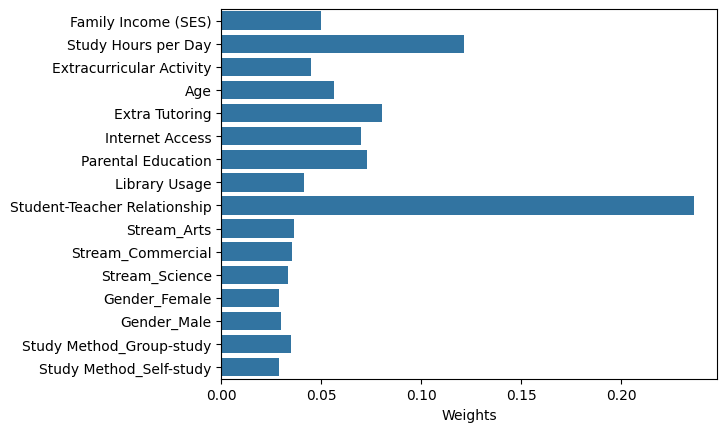

In [12]:
r_coef = best_model.feature_importances_
columns = X2.columns 
sns.barplot(y = columns, x = r_coef, orient = 'h')
plt.xlabel('Weights') 
plt.ylabel('')
plt.show()

# Recommendation and Conclusion

## Overview
The goal of this project was to create an optimized model that predicts the likelihood of a student passing or failing their upcoming exam based on their academic history. Two models were developed and evaluated: **Logistic Regression** and **Random Forest**. The focus was to assess which model performs better at predicting both outcomes (Pass or Fail) while considering various performance metrics.

## Model Performance Summary

### Logistic Regression Results:
- **Accuracy**: 71.11%
- **Precision**: 84.00%
- **Recall**: 70.00%

### Random Forest Results:
- **Accuracy**: 80.00%
- **Precision**: 86.21%
- **Recall**: 83.33%

## Discussion on Evaluation Metrics
After considering various metrics, **accuracy** was chosen as the most appropriate evaluation metric for this task. The instruction emphasizes predicting the likelihood of **passing or failing**, making accuracy a well-rounded metric that takes into account both outcomes. Since there is a moderate class imbalance, accuracy is a reliable measure of the model’s overall performance.

Other metrics like **precision** and **recall** were also analyzed:
- **Precision** ensures that the model is accurate when predicting students will pass or fail.
- **Recall** focuses on how well the model identifies actual passes or fails.

## Feature Importance Analysis

The **feature importance** from the Random Forest model provides valuable insights into the factors influencing the model's predictions. The chart below shows the most important features:


### Key Findings from Feature Importance:
- **Student-Teacher Relationship**: This was by far the most influential factor, indicating that students with better relationships with their teachers are more likely to succeed.
- **Study Hours per Day**: Another important factor, showing that the number of hours students dedicate to studying significantly affects their likelihood of passing.
- **Library Usage** and **Parental Education**: These factors also contribute notably to the prediction, highlighting the role of parental support and access to academic resources.
- Other factors like **Extra Tutoring**, **Internet Access**, and **Extracurricular Activity** also play smaller but still relevant roles in the model's prediction.

## Recommendation

Based on the accuracy and overall performance of the two models, the **Random Forest** model is the recommended choice for this task, with an accuracy of **80%** compared to **71.11%** for Logistic Regression. The Random Forest model also shows higher precision and recall scores, indicating its superior ability to correctly predict both pass and fail outcomes.

### Key Reasons for Choosing Random Forest:
1. **Higher Accuracy**: Random Forest achieved 80% accuracy, outperforming Logistic Regression.
2. **Better Precision and Recall**: Random Forest showed stronger precision and recall for both classes, ensuring better identification of passing and failing students.
3. **Feature Importance Analysis**: Random Forest provided valuable insights into which features influence student success the most, such as **Student-Teacher Relationship** and **Study Hours per Day**.

## Conclusion
The **Random Forest** model is recommended for predicting the likelihood of students passing or failing their upcoming exam based on their academic history. It provides better overall performance, making it a more reliable model for this task. Moving forward, interventions could focus on the most impactful features identified, such as improving student-teacher relationships and encouraging more study hours per day, to help students at risk of failing.


In [13]:
# joblib.dump(best_model, 'best_NEW_random_forest_model.pkl')